# Caption Anything

In this notebook, we'll illustrate the usage of [Caption Anything](https://github.com/ttengwang/Caption-Anything) step by step.

## Introduction

Caption-Anything is a versatile image processing tool that combines the capabilities of [Segment Anything](https://github.com/facebookresearch/segment-anything), Visual Captioning, and [ChatGPT](https://openai.com/blog/chatgpt). Our solution generates descriptive captions for any object within an image, offering a range of language styles to accommodate diverse user preferences. Caption-Anything supports visual controls (mouse click) and language controls (length, sentiment, factuality, and language).

## Set-up environment
We'll start by installing HuggingFace Transformers library from source as the model is brand new at the time of writing this notebook.

In [1]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/facebookresearch/segment-anything.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-wnzh9z7m
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-wnzh9z7m
  Resolved https://github.com/huggingface/transformers.git to commit 2c658b5a4282f2e824b4e23dc3bcda7ef27d5827
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.7/311.7 KB 7.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 10.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:0000:01:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 KB 12.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━

## Load image

Let's load the image from the Meta AI's [Segment Anything Demo](https://segment-anything.com/demo) or from local device.

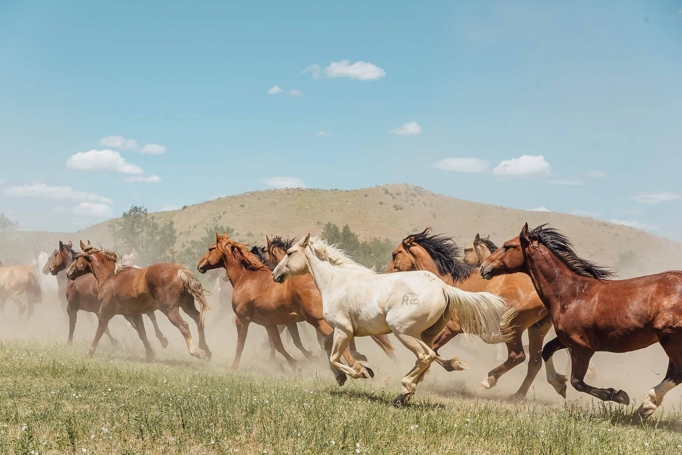

In [2]:
import requests
from PIL import Image

# from Segment Anything demo
url = 'https://segment-anything.com/assets/gallery/GettyImages-1207721867.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# # from local device
# img_path = './demo.jpg'
# image = Image.open(img_path).convert('RGB')

width, height = image.size
display(image.resize((width // 3, height // 3)))

## Load segmenter

Before using the Segment Anything Model(SAM), let's download the checkpoint of SAM and save it to the current directory.

In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-12-01 20:21:57--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.243.25, 65.8.243.111, 65.8.243.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.243.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  11.0MB/s    in 3m 50s  

2023-12-01 20:25:47 (10.6 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



Next, we leverage the downloaded checkpoint to initialize the SAM, where 'vit_h' is chosen as the backbone in our example.

It is highly recommended to run SAM in GPU! It will make generation faster.

In [6]:
import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'

# SAM initialization
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)
predictor.set_image(np.array(image)) # load the image to predictor

model

/home/brian/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

SAM produces high quality object masks from input prompts such as points or boxes, and even masks. Here, we take click prompt (i.e., points) as and example.

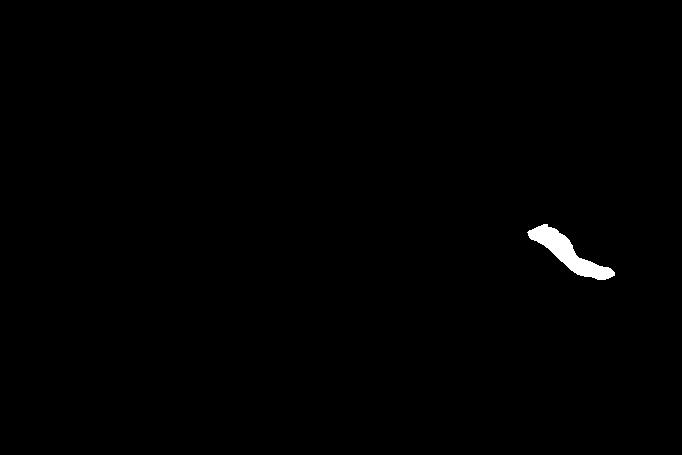

In [16]:
#input_point = [[1800, 950]] # A Nx2 array of point prompts to the model. Each point is in (X,Y) in pixels.
#input_label = [1]           # A length N array of labels for the point prompts. 1 indicates a foreground point and 0 indicates a background point.
input_point = [[1700, 800]]
input_label = [1]

input_point = np.array(input_point)
input_label = np.array(input_label)
masks, scores, logits = predictor.predict(point_coords = input_point, point_labels = input_label)
masks = masks[0, ...]

display(Image.fromarray(masks).resize(((width // 3, height // 3))))

## Crop the image

we next crop the masked objects from the origin image generated by SAM.

To crop the image, we should choose whether to remain the background of the image firstly!

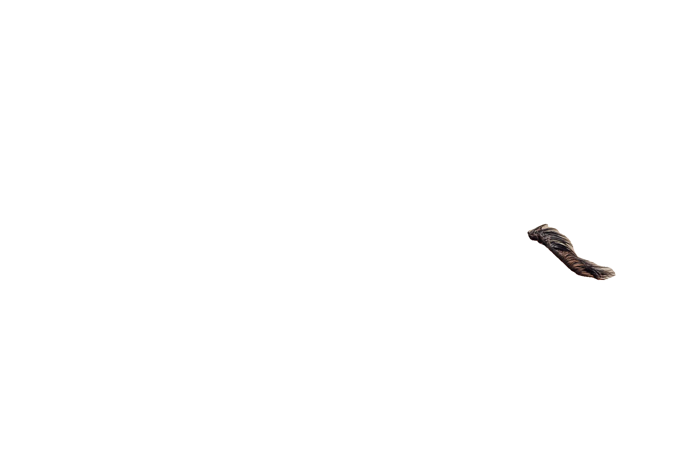

In [17]:
crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

if crop_mode == "wo_bg":
    masked_image = image * masks[:,:,np.newaxis] + (1 - masks[:,:,np.newaxis]) * 255
    masked_image = np.uint8(masked_image)
else:
    masked_image = np.array(image)
masked_image = Image.fromarray(masked_image)

display(masked_image.resize((width // 3, height // 3)))

Then, we use a regular box to cut the objects from the image as an example.

Note that the masks is a 2D matrix where 1 indicates a foreground point and 0 indicates a background point. To obtain the regular box containing masked objects, we reshape the 2D matrix to an vector, and the first 1 (A) appearing in this vector must be the point on the upper boundary of regular box. We can prove this conclusion through proof to the contrary. We suppose A is not the upper boundary of regular box which means that there is a higher foreground point (B) in the masks. When we reshape masks to an vector, B must appear before A, which is contradictory with suppose.

Once we obtain the index of A in the vector, we divide it by the number of the rows to get the position of boundary. Similarly, we can get the lower, left and right boundary too!

0.7734375 0.32861328125 0.90234375 0.41015625


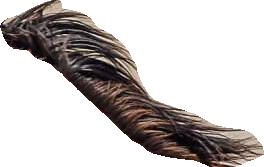

In [18]:
def boundary(inputs):
    
    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col
    
    return top, bottom

def seg_to_box(seg_mask, size):
    
    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

size = max(masks.shape[0], masks.shape[1])
left, top, right, bottom = seg_to_box(masks, size) # calculating the position of the top-left and bottom-right corners in the image
print(left, top, right, bottom)

image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
display(image_crop)

## Load captioning model

Here, we leverage BLIP2 as the captioning model. In order to accelarate the inference speed, let us start by install accelerate and bitsandbytes library to enable model acceleration and int8 quantization algorithm.

In [12]:
!pip install accelerate bitsandbytes

Defaulting to user installation because normal site-packages is not writeable


Let's load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI. We choose 2.7-billion-parameters BLIP2 as an example, for more scales, refer to: https://huggingface.co/spaces/Salesforce/BLIP2.

In [1]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
#captioning_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map = "sequential", load_in_8bit = True)

captioning_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map = "sequential", load_in_8bit = False)

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.50G [00:00<?, ?B/s]

ValueError: The current `device_map` had weights offloaded to the disk. Please provide an `offload_folder` for them. Alternatively, make sure you have `safetensors` installed if the model you are using offers the weights in this format.

Now, everything is ready, let's caption now! Defaultly, BLIP2 will start generating caption related to the image from the BOS token.

In [7]:
inputs = processor(image_crop, return_tensors = "pt").to(device, torch_dtype)
out = captioning_model.generate(**inputs, max_new_tokens = 50)
captions = processor.decode(out[0], skip_special_tokens = True).strip()

captions

'a horse running on a white background'

Optionally, text prompt can be provided to guide the process of text generation.

In [8]:
text_prompt = 'Question: What does the image show? Answer:'

inputs = processor(image_crop, text = text_prompt, return_tensors = "pt").to(device, torch_dtype)
out = captioning_model.generate(**inputs, max_new_tokens = 50)
captions = processor.decode(out[0], skip_special_tokens = True).strip()

captions

'A horse galloping'